# Other Tasks

In this notebook we investigate the correlation between degree and score for three other tasks: Drug Repositioning, Protein-Protein Interaction and Drug-Target Interaction.

## Setup

We now load the required packages, load and preprocess the Hetionet and finally load the pretrained model. Please see the `target_prediction` notebook for a more in-depth explanation of these steps.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sns
import torch
from pykeen.datasets.hetionet import Hetionet

from src.utils import get_predictions_tail, get_predictions_head

sns.set_theme(style="darkgrid", palette="muted", font_scale=1.5)

In [2]:
data = Hetionet(random_state=42)
data.summarize()  # Summarize the dataset to ensure it is downloaded
# Load the Hetionet edges as downloaded by the PyKEEN dataloader
df: pd.DataFrame = pd.read_csv(
    "~/.data/pykeen/datasets/hetionet/hetionet-v1.0-edges.sif.gz", sep="\t"
)
# Load these edges into a NX graph and compute the degree for each entity
G: nx.MultiGraph = nx.from_pandas_edgelist(
    df, "source", "target", create_using=nx.MultiGraph()
)
degs: dict = dict(G.degree())

In [3]:
# Load the completed model
model = torch.load(
    "./artifacts/transe_hetnet.pkl",
    map_location=torch.device("cpu"),
)

## Drug Repurposing 

We start with the task of Drug Repurposing, that being to find new links between compounds and diseases. In order to do this, we choose the three diseases listed below and make use of the Compound->treats->Disease (CtD) relation type from Hetionet.

In [4]:
fuchs_endothelial_dstrophy: str = "Disease::DOID:11555"
hypertension: str = "Disease::DOID:10763"
returdoid_arthritis: str = "Disease::DOID:7148"

query_relation: str = "CtD"

We can then query the model using an incomplete triple ?->treats->Disease and return the most likely compounds, as predicted by model, to treat the chosen disease. 

In [5]:
predictions_df: pd.DataFrame = get_predictions_head(
    hypertension, query_relation, data, model, degs
)
predictions_df = predictions_df[predictions_df.entity_type == "Compound"]
predictions_df.head()

,head_id,head_label,score,in_training,in_testing,entity_type,triple_type,deg
14019,14019,Compound::DB00997,-1.723628,False,False,Compound,novel,1066
13491,13491,Compound::DB00445,-1.727033,False,False,Compound,novel,1039
14245,14245,Compound::DB01234,-1.753864,False,False,Compound,novel,692
13489,13489,Compound::DB00443,-1.773928,False,False,Compound,novel,669
13728,13728,Compound::DB00694,-1.823962,False,False,Compound,novel,703


In [6]:
def plot_other_task(df: pd.DataFrame) -> None:

    ax = sns.lmplot(
        data=df,
        x="deg",
        y="score",
        hue="triple_type",
        hue_order=["novel", "train", "test"],
        logx=True,
        n_boot=10000,
        seed=0,
        aspect=1.2,
        markers=["o", "s", "x"],
        facet_kws=dict(legend_out=False),
    )
    ax.set(
        xscale="log",
        xlabel="Degree (log)",
        ylabel="Predicted Score",
        xlim=(0.5, 11000),
        ylim=(-9.5, -1),
    )
    sns.move_legend(
        ax,
        "lower right",
        bbox_to_anchor=(0.95, 0.25),
        title="Triple Type",
        frameon=False,
    )
    plt.show()

### Drug Repurposing: Hypertension

As before, we can now plot how the compound degree relates to the score assigned to it by the model. As with the gene-disease prioritization task, there is a clear correlation between the two.

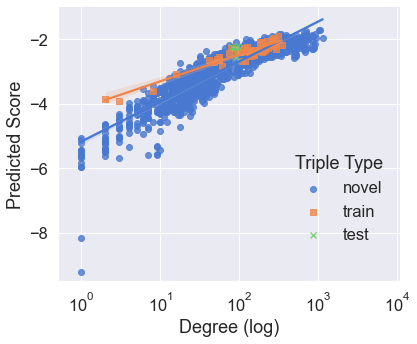

In [7]:
plot_other_task(predictions_df)

### Drug Repurposing: Fuchs Endothelial Dstrophy

This pattern holds across different diseases. 

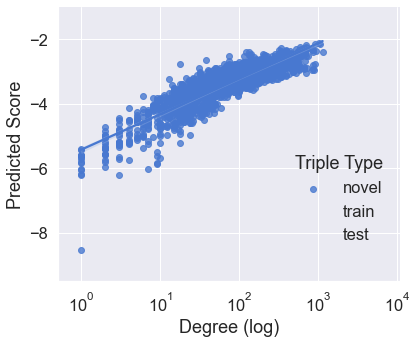

In [8]:
predictions_df: pd.DataFrame = get_predictions_head(
    fuchs_endothelial_dstrophy, query_relation, data, model, degs
)
predictions_df = predictions_df[predictions_df.entity_type == "Compound"]
plot_other_task(predictions_df)

### Drug Repurposing: Returdoid Arthritis

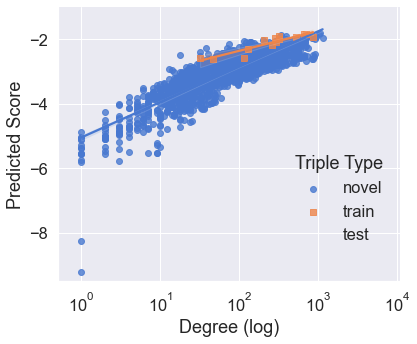

In [9]:
predictions_df: pd.DataFrame = get_predictions_head(
    returdoid_arthritis, query_relation, data, model, degs
)
predictions_df = predictions_df[predictions_df.entity_type == "Compound"]
plot_other_task(predictions_df)

## PPI Prediction

We now move to the task of Protein-Protein Interaction (PPI) prediction using three different genes and predicting likely associations using the Gene->interacts->Gene (GiG) edges from Hetionet. 

In [10]:
ubc: str = "Gene::7316"
pcna: str = "Gene::5111"
mapk1: str = "Gene::5594"

query_relation: str = "GiG"

We can query the model to return likely genes to interact with the chosen gene.

In [11]:
predictions_df: pd.DataFrame = get_predictions_tail(
    ubc, query_relation, data, model, degs
)
predictions_df = predictions_df[predictions_df.entity_type == "Gene"]
predictions_df.head()

,tail_id,tail_label,score,in_training,in_testing,entity_type,triple_type,deg
29987,29987,Gene::7316,-0.553339,False,False,Gene,novel,9372
16007,16007,Gene::10985,-2.290112,True,False,Gene,train,233
30596,30596,Gene::7965,-2.388165,False,True,Gene,test,210
28014,28014,Gene::5883,-2.393048,False,False,Gene,novel,423
27799,27799,Gene::57680,-2.414347,True,False,Gene,train,233


### PPI Prediction: UBC

Plotting this shows the relationship between entity degree and predicted score remains. Here the model, even for the highly connected gene UBC, still seems to be using connectivity when making predictions.

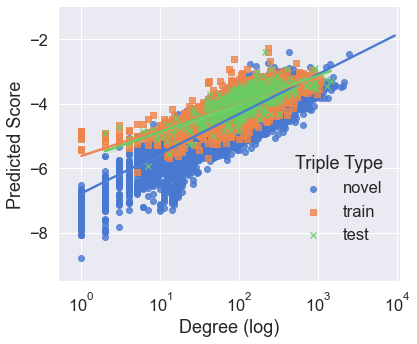

In [12]:
plot_other_task(predictions_df)

### PPI Prediction: PCNA

This also holds across different genes.

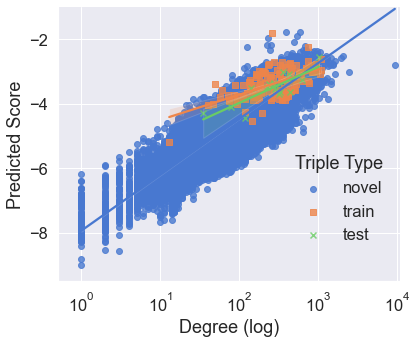

In [13]:
predictions_df: pd.DataFrame = get_predictions_tail(
    pcna, query_relation, data, model, degs
)
predictions_df = predictions_df[predictions_df.entity_type == "Gene"]
plot_other_task(predictions_df)

### PPI Prediction: MAPK1

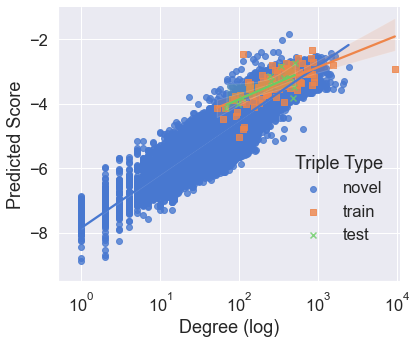

In [14]:
predictions_df: pd.DataFrame = get_predictions_tail(
    mapk1, query_relation, data, model, degs
)
predictions_df = predictions_df[predictions_df.entity_type == "Gene"]
plot_other_task(predictions_df)

## Drug Target Interaction Prediction

Lastly we consider the Drug Target Interaction (DTI) prediction task where we want to predict to which gene a compound is likely to bind. Here we use three compounds and the Compound->binds->Gene (CbG) relation type from Hetionet. 

In [15]:
doxorubicin: str = "Compound::DB00997"
auranofin: str = "Compound::DB00995"
sunitinib: str = "Compound::DB01268"

query_relation: str = "CbG"

Given a compound, we can predict likely genes for binding.

In [16]:
predictions_df: pd.DataFrame = get_predictions_tail(
    doxorubicin, query_relation, data, model, degs
)
predictions_df = predictions_df[predictions_df.entity_type == "Gene"]
predictions_df.head()

,tail_id,tail_label,score,in_training,in_testing,entity_type,triple_type,deg
18209,18209,Gene::1576,-2.289568,True,False,Gene,train,641
18215,18215,Gene::1577,-2.350110,False,False,Gene,novel,282
25668,25668,Gene::5243,-2.358113,True,False,Gene,train,530
18158,18158,Gene::1544,-2.410682,False,False,Gene,novel,371
18195,18195,Gene::1565,-2.433387,True,False,Gene,train,416


### DTI: Doxorubicin

We see the relationship between degree and score is still present in the DTI task.

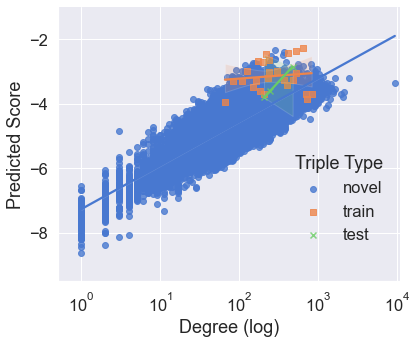

In [17]:
plot_other_task(predictions_df)

### DTI: Auranofin

The relationship seems not to depend upon the compound used.

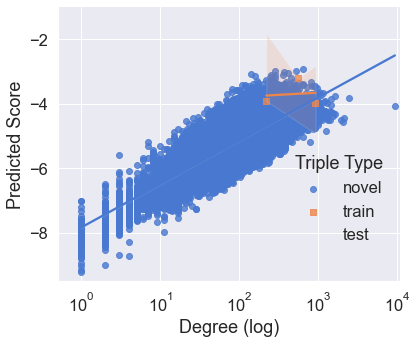

In [18]:
predictions_df: pd.DataFrame = get_predictions_tail(
    auranofin, query_relation, data, model, degs
)
predictions_df = predictions_df[predictions_df.entity_type == "Gene"]
plot_other_task(predictions_df)

### DTI: Sunitinib

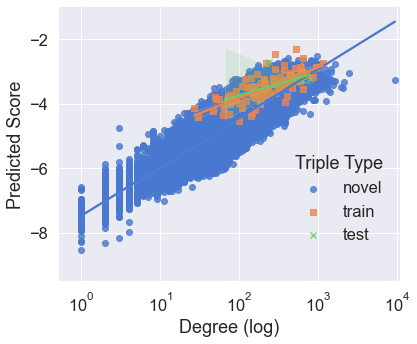

In [19]:
predictions_df: pd.DataFrame = get_predictions_tail(
    sunitinib, query_relation, data, model, degs
)
predictions_df = predictions_df[predictions_df.entity_type == "Gene"]
plot_other_task(predictions_df)